In [1]:
import importlib
import easyocr
import pytesseract as tess
import os, sys, time
import multiprocessing as mp
from PIL import Image
from ultralytics import YOLO
from src.engine.Detector import UltraDetector
from src.frame.Cascades import FrameTree
from src.config import *
from src.util.utils import *
from src.util.preprocess import *
from src.util.reader import *

importlib.reload(sys.modules['src.engine.Detector'])
importlib.reload(sys.modules['src.frame.Cascades'])
importlib.reload(sys.modules['src.util.utils'])
importlib.reload(sys.modules['src.util.preprocess'])
importlib.reload(sys.modules['src.util.reader'])
importlib.reload(sys.modules['src.config'])

<module 'src.config' from 'c:\\users\\user\\projects\\20231019-traffic-management\\src\\config.py'>

In [2]:
import copy 

def easyocr_predict(eocr_model, img, show=True):
    if len(img.shape) == 2:
        img = np.stack((img,)*3, axis=-1) # create 3 channels
    result = eocr_model.readtext(img)
    new_result = []
    img_box = copy.deepcopy(img)
    for r in result:
      box, text, prob = r
      box = np.array(box).astype(np.int32)
      img_box = draw_boxes(img_box, r)
      new_result.append([box, text, prob])
    if show: display(img_box)
    return new_result

def draw_boxes(img, r):
    box, text, prob = r
    box = np.array(box).astype(np.int32)  
    pts = np.array(box, np.int32)
    pts = pts.reshape((-1, 1, 2))
    img_box = cv2.polylines(img, [pts], True, (0, 255, 0), 2)
    # print(r)
    # print(img_box.shape)
    start_point = (max(3, box[0][0]), max(box[0][1]-10, 15))
    cv2.putText(img_box, f'{text} {prob*100:.0f}%', start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)
    return img_box

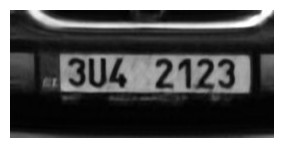

In [3]:
eocr_model = easyocr.Reader(['en'], gpu=True)
yolo_ocr = YOLO(OCR_WEIGHTS)
path = r"C:\Users\USER\Projects\20231019-traffic-management\src\assets\data\plate_sr\test_data\test_data\blurred\I1_000.png"
path = os.path.join(r"C:\Users\USER\Projects\20231019-traffic-management\src\assets\data\plate_sr\test_data\test_data\CNN-L15", os.path.basename(path).split('.')[0] + "_deblur.jpg")
display(path)
img = cv2.imread(path)
img = apply_method(resize, img, min_w=300, show=False)
img = crop(img, (56, 46, 208, 50))
# img = apply_method(rotate, img, degree=-90, show=False)
result = easyocr_predict(eocr_model, img)
print(result)
yolo_ocr_result = yolo_ocr.predict(img)
# print(yolo_ocr_result[0].boxes.xyxy)
plot_img = plot_box(img, yolo_ocr_result[0])
display(plot_img)